# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

The goal of the project is to design a Convolutional Neural Networks (CNNs / ConvNets), that can classify the German traffic signs. 

### Required Libraries

In [1]:
from os import listdir
from os.path import isfile, join
import pickle
import numpy as np
import collections
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from numpy.random import randint

---
## Step 0: Load The Data

The data is divided into three sets, one for each training, validating and finally testing the **CNN's** performance. 

In [2]:
# Load pickled data
training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. These Coordinates assume the original image. The pickled data contains resized versions (32 by 32) of these images.

### Summary of the Data

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape[0:2]

channels = X_train[0].shape[2]

# TODO: How many unique classes/labels there are in the dataset.
#Although the easy method would be to just use len(np.unique(train['labels'])), I was sure if there was a fare distribution 
#in classes in the three datasets, hence I concatenated thethree datasets.
n_classes = len(np.unique(np.concatenate((train['labels'],valid['labels'],test['labels']),axis=0)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of channels in image =", channels)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of channels in image = 3
Number of classes = 43


There is a total of 43 different classes in the German Traffic Signs Datatset. The data has also been split into the percentages. 

In [8]:
print("Percentage of training examples =", round((n_train/sum([n_train,n_validation,n_test])) *100,2))
print("Percentage of validation examples =",round((n_validation/sum([n_train,n_validation,n_test])) *100,2))
print("Percentage of testing examples =", round((n_test/sum([n_train,n_validation,n_test])) *100,2))

Percentage of training examples = 67.13
Percentage of validation examples = 8.51
Percentage of testing examples = 24.36


### Exploratory Visualization of the Dataset

#### Required Libraries for Plotting 

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#### Visualize the Images

In [5]:
#Load the Class Id and the corresponding sign name for each traffic sign from the signnames.csv file.
SIGN_NAME_FILE = 'signnames.csv'
sign_name = pd.read_csv(SIGN_NAME_FILE)

**Example of images in the German traffic signs dataset**

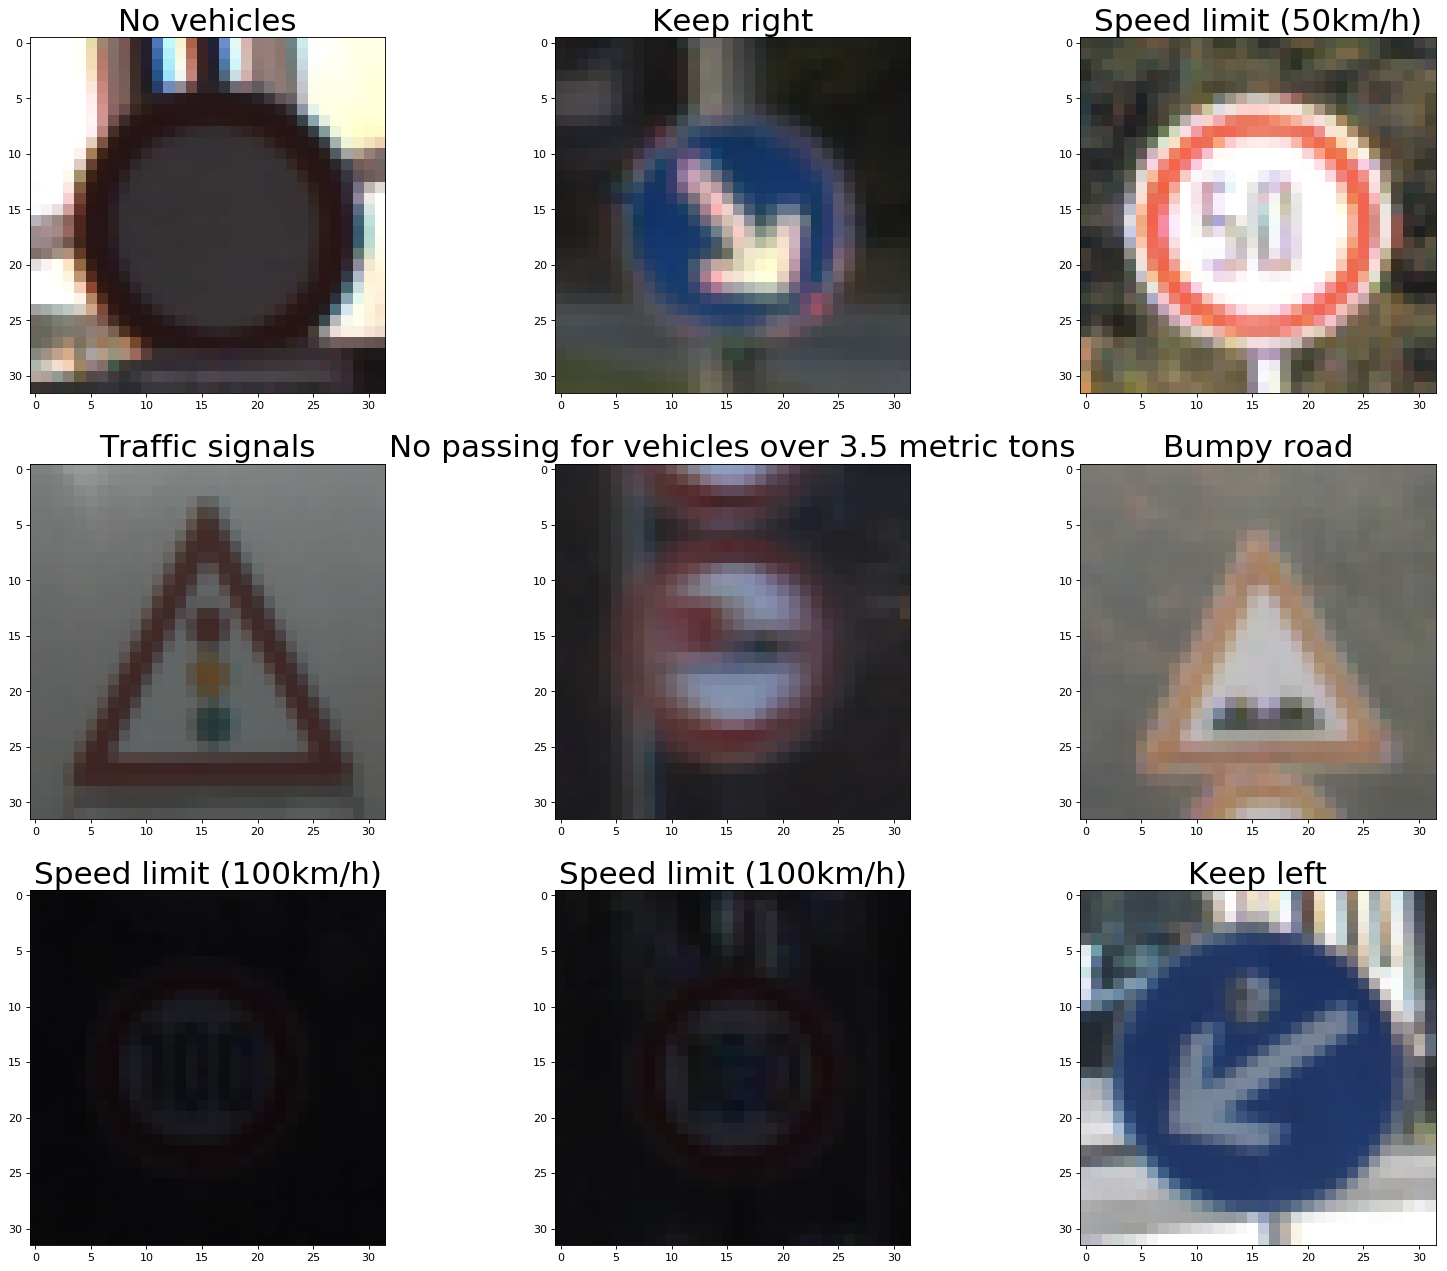

In [9]:
fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
num = 0
for i in range(9):
    y = fig.add_subplot(3,3,num+1)
    index = np.random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    y.set_title(sign_name['SignName'][y_train[index]],fontsize=28)
    y.imshow(image)
    num+=1
plt.show()

### Class Distribution

In [10]:
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#Helper function to change the y-ticks  into percentages
def to_percent(y, position):
    s = str(100 * y)
    if rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


### Class Distribution for Training Data

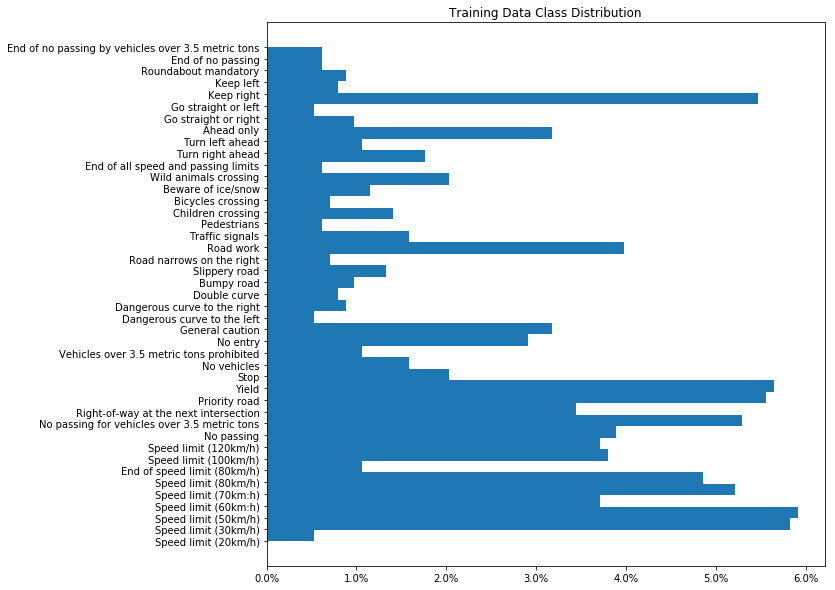

In [11]:
plt.figure(figsize=(10,10))
plt.hist(train['labels'],bins=43,normed=True,orientation='horizontal')
plt.yticks(sign_name['ClassId'],sign_name['SignName'])
formatter = FuncFormatter(to_percent)
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Training Data Class Distribution')
plt.show()

### Class Distribution for Validation Data

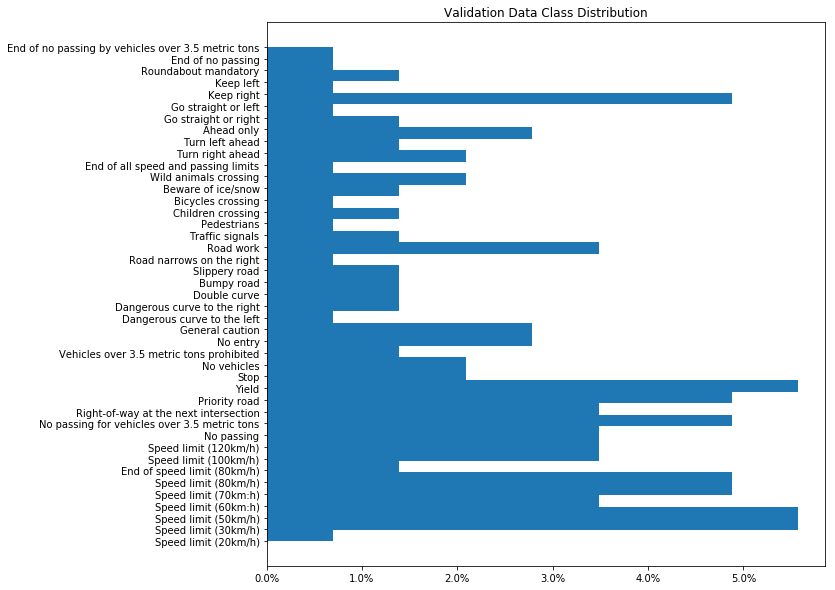

In [12]:
plt.figure(figsize=(10,10))
plt.hist(valid['labels'],bins=43,normed=True,orientation='horizontal')
plt.yticks(sign_name['ClassId'],sign_name['SignName'])
formatter = FuncFormatter(to_percent)
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Validation Data Class Distribution')
plt.show()

### Class Distribution for Test Data

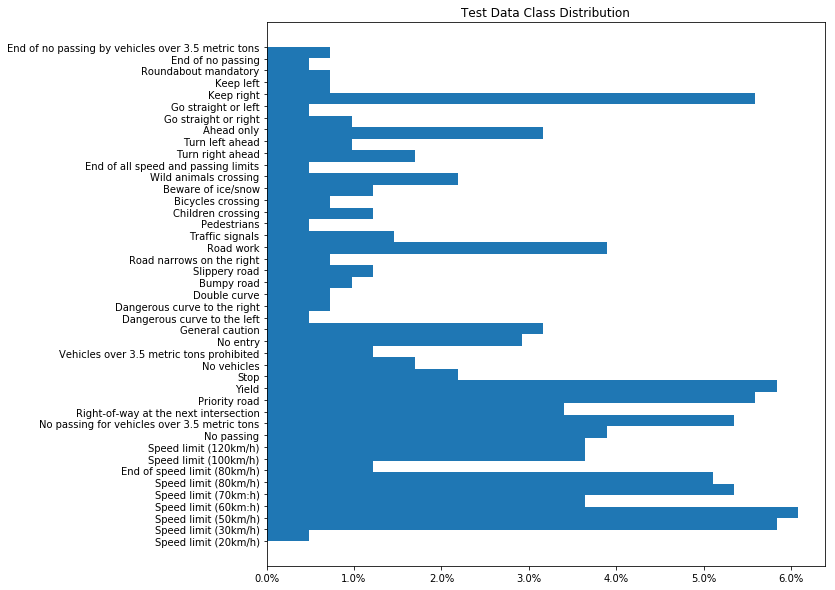

In [13]:
plt.figure(figsize=(10,10))
plt.hist(test['labels'],bins=43,normed=True,orientation='horizontal')
plt.yticks(sign_name['ClassId'],sign_name['SignName'])
formatter = FuncFormatter(to_percent)
plt.gca().xaxis.set_major_formatter(formatter)
plt.title('Test Data Class Distribution')
plt.show()

From the above three plots it can be seen that stratified sampling technique had been used to seperate the data into the three sets, i.e.( Training, Validating and Testing), as each dataset has a similar distribution. However, the percentage of Traffic sign classes in each dataset is not equally distributed as there is a higher percentage of some traffic sign classes than others in each of the datasets. This in turn may result in the **CNN** overfitting the traffic sign classes that are more common in tha dataset. 

----

## Step 2: Design and Test a Model Architecture

This step involves designing and implementing a deep learning model that learns to recognize traffic signs. The model is  trained and tested on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) was used as a starting point.

The LeNet-5 implementation, resulted in a validation set accuracy of about 0.89 and therefore a higher performing CNN would need to be designed in order to complete the project successfully. 

There are various aspects to consider when designing the Deep Neural Network, which includes:

- Neural network architecture (is the network over or underfitting?)
- Applying preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generating fake data.

This is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [14]:
def normalize_image_data(image_data):
    return (image_data - [128])/[128]

### Add Percentages to the Data Frame
Add the percenetage of occurences in the training dataset for each of traffic signs to the ```sign_name``` data frame.

In [15]:
counter_dict = collections.Counter(y_train)
total = len(y_train)
sign_name['percentages'] = [(counter_dict[n]/total) for n in sign_name['ClassId']]
print(sign_name.head(5))

   ClassId              SignName  percentages
0        0  Speed limit (20km/h)     0.005173
1        1  Speed limit (30km/h)     0.056898
2        2  Speed limit (50km/h)     0.057760
3        3  Speed limit (60km:h)     0.036208
4        4  Speed limit (70km:h)     0.050864


### Augment the Images in the Dataset
This section consists of helper functions to augment the traffic sign images. The traffic sign images which are augmented are those whose percentage of occurences in the training dataset is less than the set ```THRESHOLD``` value and the images are also augmented at random.

The following augmentations are applied to the images
- Random Transpose
- Flip Left to Right
- Random Contrast
- Random Brightness


In [16]:
THRESHOLD = 0.015

def random_transpose_image(image_data,labels,percentage_of_data,sign_name):
    sess = tf.InteractiveSession()
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    total_num_images = image_data.shape[0]
    num_of_augmented_images = round(total_num_images * percentage_of_data)
    augmented_image_list = []
    augmented_label_list = []
    while len(augmented_image_list) < num_of_augmented_images:
        index = randint(low=0,high=total_num_images)
        if sign_name['percentages'][labels[index]] < THRESHOLD:
            augmented_label_list.append(labels[index])
            augmented_image_list.append(tf.image.transpose_image(image_data[index]).eval())
    return augmented_image_list,augmented_label_list

def random_flip_left_right(image_data,labels,percentage_of_data,sign_name):
    sess = tf.InteractiveSession()
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    total_num_images = image_data.shape[0]
    num_of_augmented_images = round(total_num_images * percentage_of_data)
    augmented_image_list = []
    augmented_label_list = []
    while len(augmented_image_list) < num_of_augmented_images:
        index = randint(low=0,high=total_num_images)
        if sign_name['percentages'][labels[index]] < THRESHOLD:
            augmented_label_list.append(labels[index])
            augmented_image_list.append(tf.image.flip_left_right(image_data[index]).eval())
    return augmented_image_list,augmented_label_list


def random_contrast(image_data,labels,percentage_of_data,sign_name,lower,upper):
    sess = tf.InteractiveSession()
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    total_num_images = image_data.shape[0]
    num_of_augmented_images = round(total_num_images * percentage_of_data)
    augmented_image_list = []
    augmented_label_list = []
    while len(augmented_image_list) < num_of_augmented_images:
        index = randint(low=0,high=total_num_images)
        if sign_name['percentages'][labels[index]] < THRESHOLD:
            augmented_label_list.append(labels[index])
            augmented_image_list.append(tf.image.random_contrast(image_data[index],lower,upper).eval())
    return augmented_image_list,augmented_label_list


def random_brightness(image_data,labels,percentage_of_data,sign_name):
    sess = tf.InteractiveSession()
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    total_num_images = image_data.shape[0]
    num_of_augmented_images = round(total_num_images * percentage_of_data)
    augmented_image_list = []
    augmented_label_list = []
    while len(augmented_image_list) < num_of_augmented_images:
        index = randint(low=0,high=total_num_images)
        if sign_name['percentages'][labels[index]] < THRESHOLD:
            augmented_label_list.append(labels[index])
            delta = np.random.uniform(0.2,0.7)
            augmented_image_list.append(tf.image.adjust_brightness(image_data[index],delta).eval())
    return augmented_image_list,augmented_label_list

In [18]:
def show_transforms(images,labels): 
    sess = tf.InteractiveSession()
    fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
    index = randint(low=0,high=images.shape[0],size=5) 

    y = fig.add_subplot(4,2,1)
    y.set_title( "Before: ("+ sign_name['SignName'][labels[index[0]]]+")",fontsize=12)
    y.set_ylabel("Before Transpose",labelpad=40)
    y.imshow(images[index[0]])

    y = fig.add_subplot(4,2,2)
    y.set_title("After: ("+ sign_name['SignName'][labels[index[0]]]+")",fontsize=12)
    image_transform_0 = tf.image.transpose_image(images[index[0]]).eval()
    y.set_ylabel("After Transpose",labelpad=40)
    y.imshow(image_transform_0)

    y = fig.add_subplot(4,2,3) 
    y.set_title( "Before: ("+ sign_name['SignName'][labels[index[1]]]+")",fontsize=12)
    y.set_ylabel("Before Left-Right Flip",labelpad=40)
    y.imshow(images[index[1]])

    y = fig.add_subplot(4,2,4)
    y.set_title("After: ("+ sign_name['SignName'][labels[index[1]]]+")",fontsize=12)
    image_transform_1 = tf.image.flip_left_right(images[index[1]]).eval()
    y.set_ylabel("After Left-Right Flip",labelpad=40)
    y.imshow(image_transform_1)

    y = fig.add_subplot(4,2,5)
    y.set_title( "Before: ("+ sign_name['SignName'][labels[index[3]]]+")",fontsize=12)
    y.set_ylabel("Before Random Contrast",labelpad=40)
    y.imshow(images[index[3]])

    y = fig.add_subplot(4,2,6)
    y.set_title("After: ("+ sign_name['SignName'][labels[index[3]]]+")",fontsize=12) 
    image_transform_3 = tf.image.random_contrast(images[index[3]],0,3).eval()
    y.set_ylabel("After Random Contrast",labelpad=40)
    y.imshow(image_transform_3)

    y = fig.add_subplot(4,2,7)
    y.set_title( "Before: ("+ sign_name['SignName'][labels[index[4]]]+")",fontsize=12) 
    y.set_ylabel("Before Brightness",labelpad=40)
    y.imshow(images[index[4]])

    y = fig.add_subplot(4,2,8)
    y.set_title("After: ("+ sign_name['SignName'][labels[index[4]]]+")",fontsize=12) 
    image_transform_4 = tf.image.adjust_brightness(images[index[4]],np.random.uniform(0.2,0.7)).eval() 
    y.set_ylabel("After Brightness",labelpad=40)
    y.imshow(image_transform_4)

    plt.show() 

### Image Augmentation Outcome

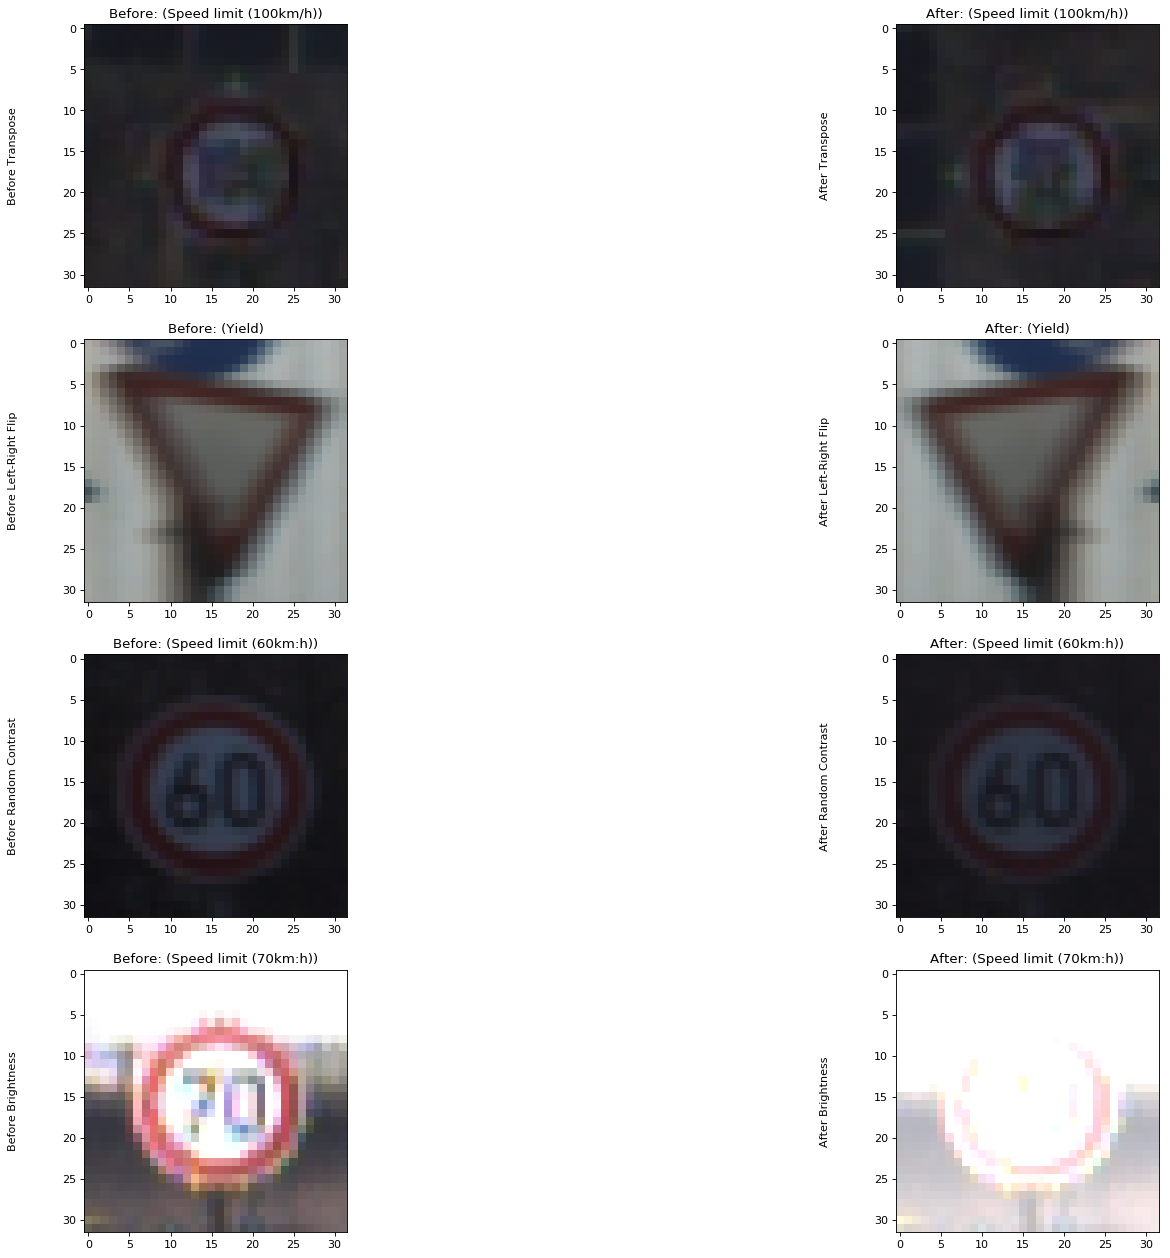

In [19]:
show_transforms(X_train,y_train) 

#### Preprocess, Augment & Shuffle the Data

A total of 20% of the training data is augmented, using the above defined augmentation function.

In [20]:
augmented_data = []

X_data, y_data = random_transpose_image(X_train,y_train,0.005,sign_name)
augmented_data.append((X_data, y_data))

X_data, y_data = random_flip_left_right(X_train,y_train,0.005,sign_name)
augmented_data.append((X_data, y_data))

X_data, y_data = random_contrast(X_train,y_train,0.005,sign_name,0,3)
augmented_data.append((X_data, y_data))

X_data, y_data = random_brightness(X_train,y_train,0.005,sign_name)
augmented_data.append((X_data, y_data))

for augmented_X_data, augmented_y_data in augmented_data:
    X_train = np.concatenate((X_train,augmented_X_data),axis=0)
    y_train = np.concatenate((y_train,augmented_y_data),axis=0)


#Preprocess Training Data
X_train = normalize_image_data(X_train)


#Preprocess Validation Data
X_valid = normalize_image_data(X_valid)


#Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

print("Processing Data Finished..")

Processing Data Finished..


### Model Architectures

#### LeNet Architecture

In [21]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,6),mean=mu,stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_W,strides=[1,1,1,1],padding='VALID') + conv1_b
    
    
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides =[1,2,2,1],padding='VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5,5,6,16),mean=mu,stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1,conv2_W,strides=[1,1,1,1],padding='VALID') + conv2_b
    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides =[1,2,2,1],padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120),mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0,fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84),mean=mu,stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_W) + fc2_b
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    out_W = tf.Variable(tf.truncated_normal(shape=(84,43),mean=mu,stddev=sigma))
    out_b= tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,out_W)+ out_b
    
    return logits

#### CustomNet Architecture

In [22]:
def CustomNet(x,keep_prob):
    mu = 0
    sigma = 0.1
    
    #INPUT = 32X32X3 OUTPUT = 30X30X12
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3,3,3,12),mean=mu,stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1 = tf.nn.conv2d(x,conv1_W,strides=[1,1,1,1],padding='VALID') + conv1_b
    CustomNet.conv1 = tf.nn.relu(conv1)
    
    #INPUT = 30X30X12 OUTPUT = 28X28X16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3,3,12,16),mean=mu,stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(CustomNet.conv1,conv2_W,strides=[1,1,1,1],padding='VALID') + conv2_b
    CustomNet.conv2 = tf.nn.relu(conv2)
    
    #INPUT = 28X28X16 OUTPUT = 14X14X16
    CustomNet.maxpool1 = tf.nn.max_pool(CustomNet.conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    #INPUT = 14X14X16 OUTPUT = 12X12X20
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3,3,16,20),mean=mu,stddev=sigma))
    conv3_b = tf.Variable(tf.zeros(20))
    conv3 = tf.nn.conv2d(CustomNet.maxpool1,conv3_W,strides=[1,1,1,1],padding='VALID') + conv3_b
    CustomNet.conv3 = tf.nn.relu(conv3)
    
    #INPUT = 12X12X20 OUTPUT = 10X10X24
    conv4_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,24),mean=mu,stddev=sigma))
    conv4_b = tf.Variable(tf.zeros(24))
    conv4 = tf.nn.conv2d(CustomNet.conv3,conv4_W,strides=[1,1,1,1],padding='VALID') + conv4_b
    CustomNet.conv4 = tf.nn.relu(conv4)
    
    #INPUT = 10X10X24 OUTPUT = 5X5X24
    CustomNet.maxpool2 = tf.nn.max_pool(CustomNet.conv4,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    #INPUT = 5X5X24 OUTPUT = 600
    CustomNet.fc0 = flatten(CustomNet.maxpool2)
    
    #INPUT = 600 OUTPUT = 400
    fc1_W = tf.Variable(tf.truncated_normal(shape=(600,400),mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    CustomNet.fc1 = tf.matmul(CustomNet.fc0,fc1_W) + fc1_b
    CustomNet.fc1 = tf.nn.relu(CustomNet.fc1)
    CustomNet.fc1 = tf.nn.dropout(CustomNet.fc1,keep_prob)
    
    #INPUT = 400 OUTPUT = 200
    fc2_W = tf.Variable(tf.truncated_normal(shape=(400,200),mean=mu,stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(200))
    CustomNet.fc2 = tf.matmul(CustomNet.fc1,fc2_W) + fc2_b
    CustomNet.fc2 = tf.nn.relu(CustomNet.fc2)
    CustomNet.fc2 = tf.nn.dropout(CustomNet.fc2,keep_prob)
    
    #INPUT = 200 OUTPUT = 43
    fc3_W = tf.Variable(tf.truncated_normal(shape=(200,43),mean=mu,stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    CustomNet.logits = tf.matmul(CustomNet.fc2,fc3_W) + fc3_b
    
    return CustomNet.logits
    
    
    
    

#### AlexNet Architecture

In [23]:
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''
    From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i % group == 0
    assert c_o % group == 0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)

    if tf.__version__ < "1.0.0":
        if group == 1:
            conv = convolve(input, kernel)
        else:
            input_groups = tf.split(3, group, input)
            kernel_groups = tf.split(3, group, kernel)
            output_groups = [convolve(i, k) for i, k in zip(input_groups, kernel_groups)]
            conv = tf.concat(3, output_groups)
    else:
        if group == 1:
            conv = convolve(input, kernel)
        else:
            input_groups = tf.split(input, group, 3)
            kernel_groups = tf.split(kernel, group, 3)
            output_groups = [convolve(i, k) for i, k in zip(input_groups, kernel_groups)]
            conv = tf.concat(output_groups, 3)
    return tf.reshape(tf.nn.bias_add(conv, biases), [-1] + conv.get_shape().as_list()[1:])


def AlexNet(x):
    mu = 0
    sigma = 0.1
    
    x = tf.image.resize_images(x,(227,227))
    
    # conv1
    # conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
    k_h = 11
    k_w = 11
    c_o = 96
    s_h = 4
    s_w = 4
    conv1W = tf.Variable(tf.truncated_normal(shape = (11,11,3,96),mean=mu,stddev=sigma))
    conv1b = tf.Variable(tf.zeros(96))
    conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
    conv1 = tf.nn.relu(conv1_in)

    # lrn1
    # lrn(2, 2e-05, 0.75, name='norm1')
    radius = 2
    alpha = 2e-05
    beta = 0.75
    bias = 1.0
    lrn1 = tf.nn.local_response_normalization(conv1, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)

    # maxpool1
    # max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
    k_h = 3
    k_w = 3
    s_h = 2
    s_w = 2
    padding = 'VALID'
    maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    # conv2
    # conv(5, 5, 256, 1, 1, group=2, name='conv2')
    k_h = 5
    k_w = 5
    c_o = 256
    s_h = 1
    s_w = 1
    group = 2
    conv2W = tf.Variable(tf.truncated_normal(shape = (5,5,48,256),mean=mu,stddev=sigma))
    conv2b = tf.Variable(tf.zeros(256))
    conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv2 = tf.nn.relu(conv2_in)

    # lrn2
    # lrn(2, 2e-05, 0.75, name='norm2')
    radius = 2
    alpha = 2e-05
    beta = 0.75
    bias = 1.0
    lrn2 = tf.nn.local_response_normalization(conv2, depth_radius=radius, alpha=alpha, beta=beta, bias=bias)

    # maxpool2
    # max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
    k_h = 3
    k_w = 3
    s_h = 2
    s_w = 2
    padding = 'VALID'
    maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    # conv3
    # conv(3, 3, 384, 1, 1, name='conv3')
    k_h = 3
    k_w = 3
    c_o = 384
    s_h = 1
    s_w = 1
    group = 1
    conv3W = tf.Variable(tf.truncated_normal(shape = (3,3,256,384),mean =mu,stddev=sigma))
    conv3b = tf.Variable(tf.zeros(384))
    conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv3 = tf.nn.relu(conv3_in)

    # conv4
    # conv(3, 3, 384, 1, 1, group=2, name='conv4')
    k_h = 3
    k_w = 3
    c_o = 384
    s_h = 1
    s_w = 1
    group = 2
    conv4W = tf.Variable(tf.truncated_normal(shape = (3,3,192,384),mean =mu,stddev=sigma))
    conv4b = tf.Variable(tf.zeros(384))
    conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv4 = tf.nn.relu(conv4_in)

    # conv5
    # conv(3, 3, 256, 1, 1, group=2, name='conv5')
    k_h = 3
    k_w = 3
    c_o = 256
    s_h = 1
    s_w = 1
    group = 2
    conv5W = tf.Variable(tf.truncated_normal(shape = (3,3,192,256),mean=mu,stddev=sigma))
    conv5b = tf.Variable(tf.zeros(256))
    conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
    conv5 = tf.nn.relu(conv5_in)

    # maxpool5
    # max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
    k_h = 3
    k_w = 3
    s_h = 2
    s_w = 2
    padding = 'VALID'
    maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

    # fc6, 4096
    fc6W = tf.Variable(tf.truncated_normal(shape = (9216,4096),mean=mu,stddev=sigma))
    fc6b = tf.Variable(tf.zeros(4096))
    flat5 = tf.reshape(maxpool5, [-1, int(np.prod(maxpool5.get_shape()[1:]))])
    fc6 = tf.nn.relu(tf.matmul(flat5, fc6W) + fc6b)

    # fc7, 4096
    fc7W = tf.Variable(tf.truncated_normal(shape = (4096,4096),mean=mu,stddev=sigma))
    fc7b = tf.Variable(tf.zeros(4096))
    fc7 = tf.nn.relu(tf.matmul(fc6, fc7W) + fc7b)


    # fc8, 43
    fc8W = tf.Variable(tf.truncated_normal(shape = (4096,43),mean=mu,stddev=sigma))
    fc8b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc7, fc8W) + fc8b
    
    return logits

## Train, Validate and Test the Model

### Features, Labels and Network Parameters

- `x` is a placeholder for a batch of input images.
- `y` is a placeholder for a batch of output labels.
- `keep_prob` is a placeholder for the input parameter in CustomNet.

In [24]:
#None indicates batch size, so therefore later it can take a value (i.e. batch size of any value)
x = tf.placeholder(tf.float32, (None, 32, 32, 3)) #Where None is for batch size
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32,(None))#None is to specify the keep probability for Dropout
one_hot_y = tf.one_hot(y, 43) #one hot encoder

## Setup Epoch & Batch Size
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [25]:
EPOCHS = 25
BATCH_SIZE = 128

## Training Pipeline
The training pipeline that uses the CustomNet model to classify Traffic Sign data.

In [26]:
rate = 0.001 #Learning rate
logits = CustomNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate) #Uses Adam Optimizer
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation Function
The ```evaluate``` function evaluates the loss and accuracy of the model for a given dataset.

In [27]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
save_file = './customnet.ckpt'
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train, Validate & Evaluate the Model
1. Run the training data through the training pipeline to train the model.
2. Before each epoch, shuffle the training set.
3. After each epoch, measure the loss and accuracy on the validation set.
4. Save the model after each epoch, only when there is increase in validation accuracy.

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    accuracy_list = []
    best_accuracy = 0
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.8})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if i == 0:
            best_accuracy = validation_accuracy
        elif validation_accuracy > best_accuracy:
            print("Validation Accuracy increased by {}".format(validation_accuracy - best_accuracy))
            saver.save(sess, save_file)
            print("Model saved")
            best_accuracy = validation_accuracy
        accuracy_list.append(validation_accuracy)

Training...

EPOCH 1 ...
Validation Accuracy = 0.838

EPOCH 2 ...
Validation Accuracy = 0.932

Validation Accuracy increased by 0.09455782285893577
Model saved
EPOCH 3 ...
Validation Accuracy = 0.941

Validation Accuracy increased by 0.008163265306122547
Model saved
EPOCH 4 ...
Validation Accuracy = 0.951

Validation Accuracy increased by 0.010204081902968842
Model saved
EPOCH 5 ...
Validation Accuracy = 0.955

Validation Accuracy increased by 0.004535147121974448
Model saved
EPOCH 6 ...
Validation Accuracy = 0.951

EPOCH 7 ...
Validation Accuracy = 0.953

EPOCH 8 ...
Validation Accuracy = 0.963

Validation Accuracy increased by 0.007482993197278853
Model saved
EPOCH 9 ...
Validation Accuracy = 0.965

Validation Accuracy increased by 0.0020408163265306367
Model saved
EPOCH 10 ...
Validation Accuracy = 0.966

Validation Accuracy increased by 0.0013605442176870541
Model saved
EPOCH 11 ...
Validation Accuracy = 0.963

EPOCH 12 ...
Validation Accuracy = 0.964

EPOCH 13 ...
Validation Accur

#### Plot Validation Accuracy over each Epoch

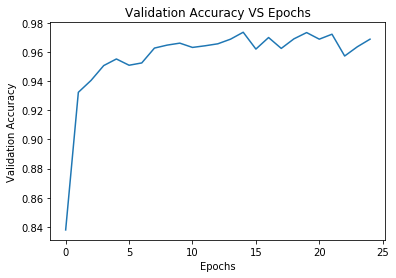

In [29]:
plt.plot([i for i in range(EPOCHS)],accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy VS Epochs')
plt.show()

## Test the Model
Evaluate the model accuracy on the test dataset.

In [30]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.909


---

## Step 3: Test the Model on New Images

To give more insight into how the model is working, A set of five pictures of German traffic signs were downloaded from the web and the model is used to predict the traffic sign type.

Helper functions, to display the images and to get the predictions.

In [31]:
#Helper function to get id no. from label
def get_class_ids(labels):
    idxs = []
    for label in labels:
        idxs.append(sign_name['ClassId'][sign_name['SignName'].tolist().index(label)])
    return idxs

#Helper function resize image
def resize_images(images):
    return np.array([cv2.resize(image,(32,32)) for image in images])

#Helper function get probablilities
def get_predictions(X_data,top):
    with tf.Session() as sess:
        saver.restore(sess, save_file)
        return sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=top),feed_dict={x:X_data,keep_prob:1.0})
    
#Helper function to display the image and the corresponding predictions  
def display_images_predictions(images,predictions,image_real_labels):
    fig = plt.figure(figsize=(24,20),dpi=80,facecolor='w',edgecolor='k')
    num=1
    for image, prediction,ids,title in zip(images,predictions[0],predictions[1],image_real_labels):
        img = fig.add_subplot(5,2,num)
        img.set_title(title)
        img.imshow(image)
        
        num+=1
        
        plot=fig.add_subplot(5,2,num)
        labels = [sign_name['SignName'][index] for index in ids]
        plot.barh(np.arange(len(labels)),prediction)
        plot.set_yticks(np.arange(len(labels)))
        plot.set_yticklabels(labels)
        plot.invert_yaxis()  
        plot.set_title("Top 5 Predicitions")
        num+=1
        
    plt.show()
    

### Load and Output the Dowloaded Images

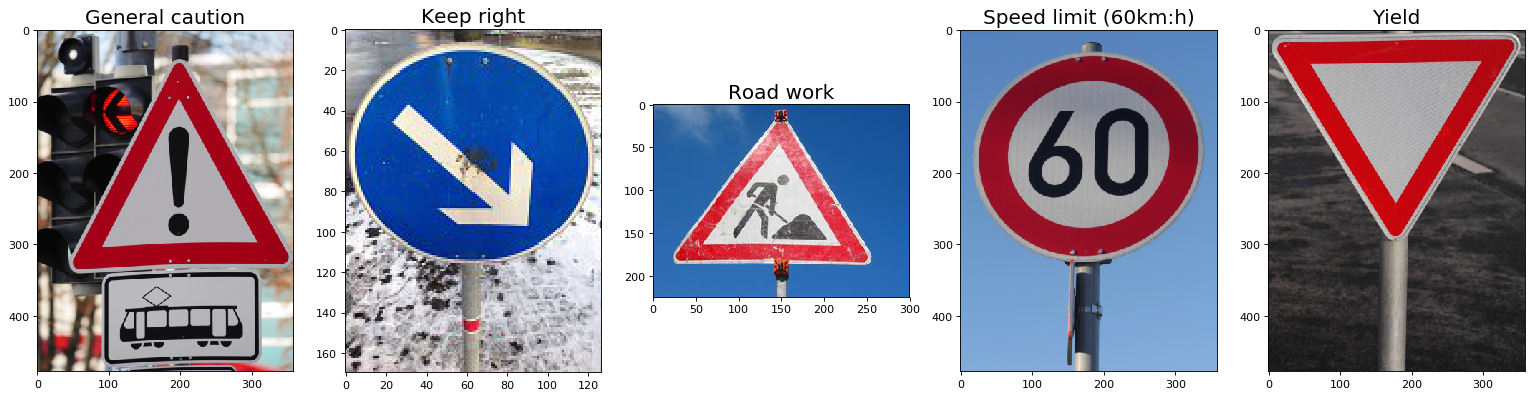

In [32]:
test_images = [plt.imread(join('test-images/', f)) for f in listdir('test-images')]
test_images_labels = [' '.join(f[:-4].split('_')) for f in listdir('test-images')]
fig=plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
num=0 
for image in test_images:
    z = fig.add_subplot(1,5,num+1)
    z.set_title(test_images_labels[num],fontsize=18)
    z.imshow(image)
    num+=1
plt.show()

test_images_resized = resize_images(test_images)
class_ids = get_class_ids(test_images_labels)

### Predict the Sign Type for Each Image

Resulting prediction accuracy for the downloaded images.

In [33]:
with tf.Session() as sess:
    saver.restore(sess, save_file)
    accuracy = evaluate(test_images_resized, class_ids)
    print("Accuracy Of New Test Images = {:.3f}".format(accuracy))

Accuracy Of New Test Images = 0.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

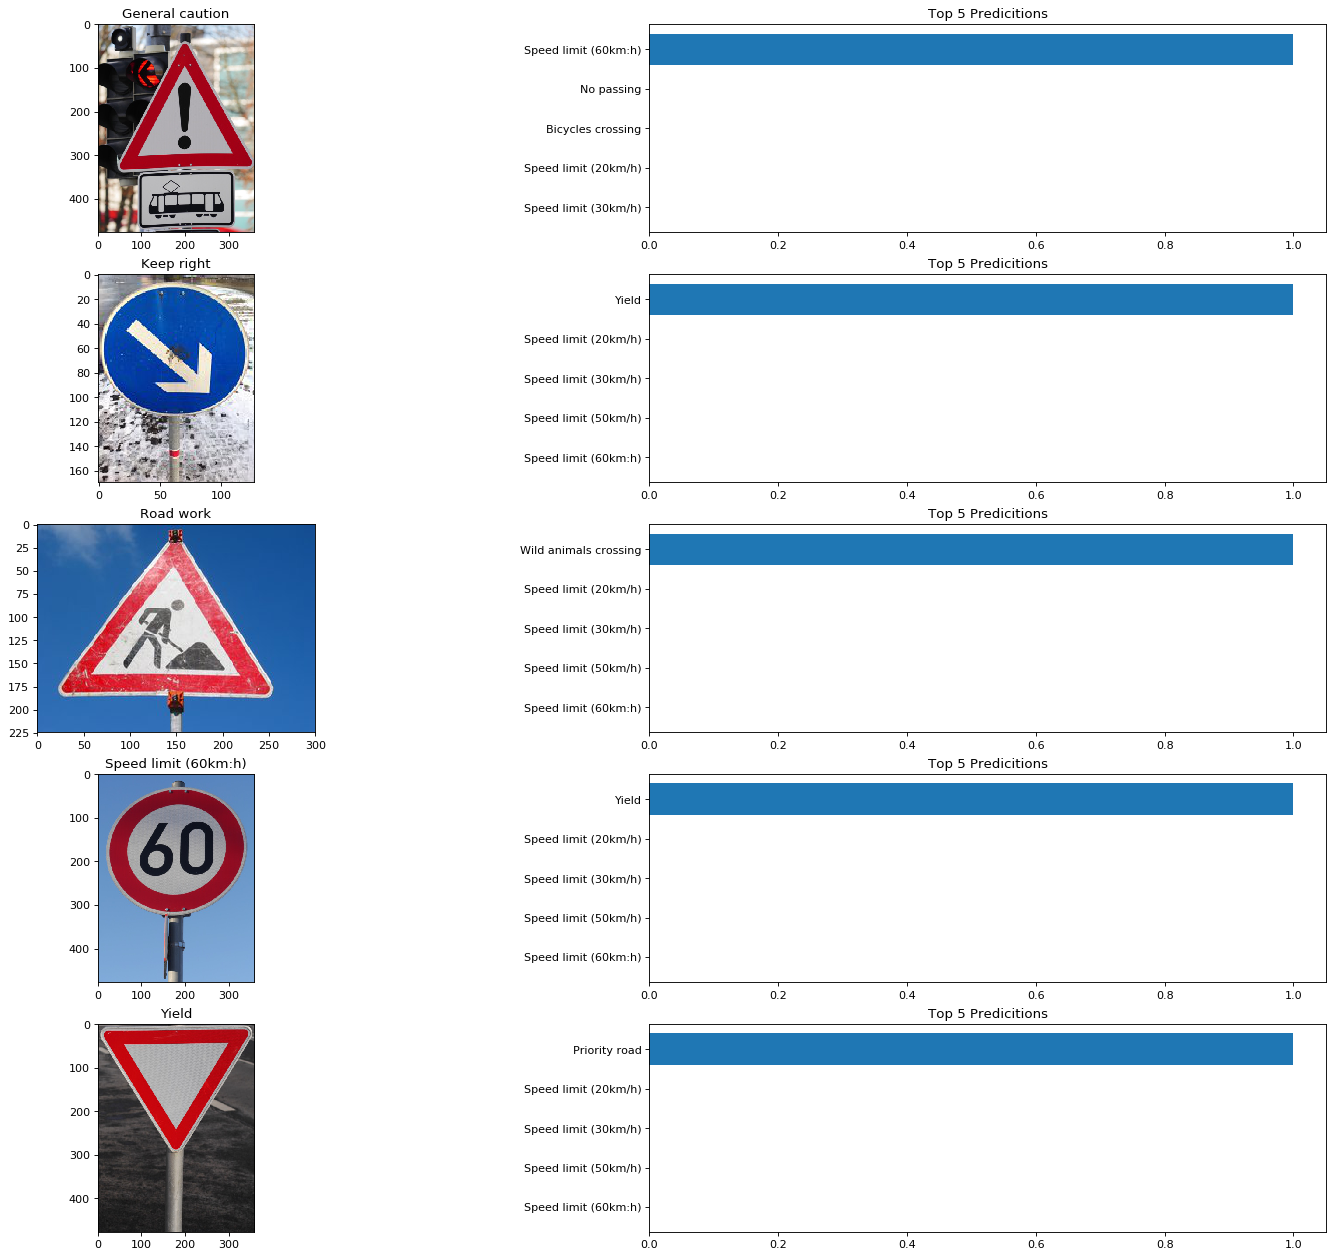

In [34]:
display_images_predictions(test_images,get_predictions(test_images_resized,5),test_images_labels)

---

## Step 4: Visualize the Neural Network's State with Test Images


In [35]:
### Visualize the network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, save_file)
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

#### Input Image 

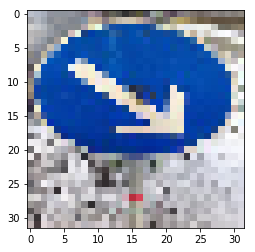

In [36]:
input_image = np.array([test_images_resized[1]])
plt.imshow(input_image[0])

#### First Convolutuion Layer Feature Map

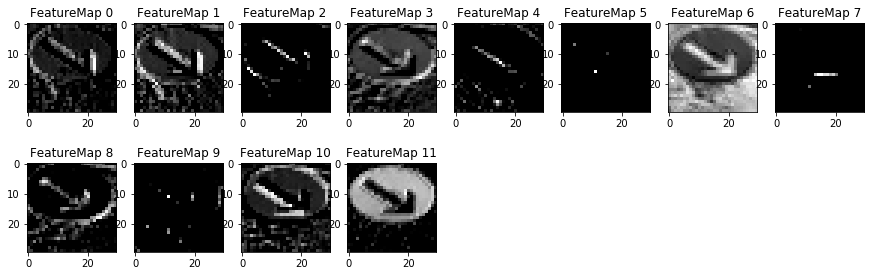

In [37]:
outputFeatureMap(input_image,CustomNet.conv1)

#### Second Convolutuion Layer Feature Map

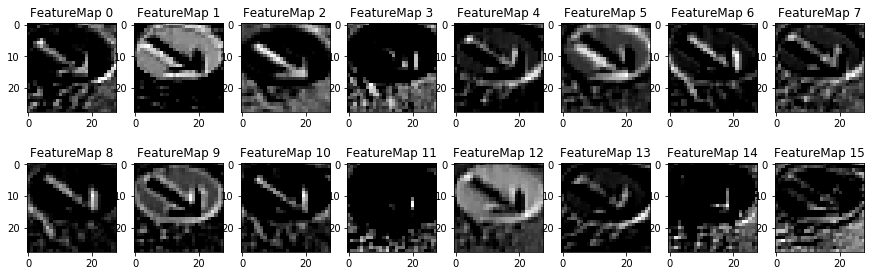

In [38]:
outputFeatureMap(input_image,CustomNet.conv2)

#### Third Convolutuion Layer Feature Map

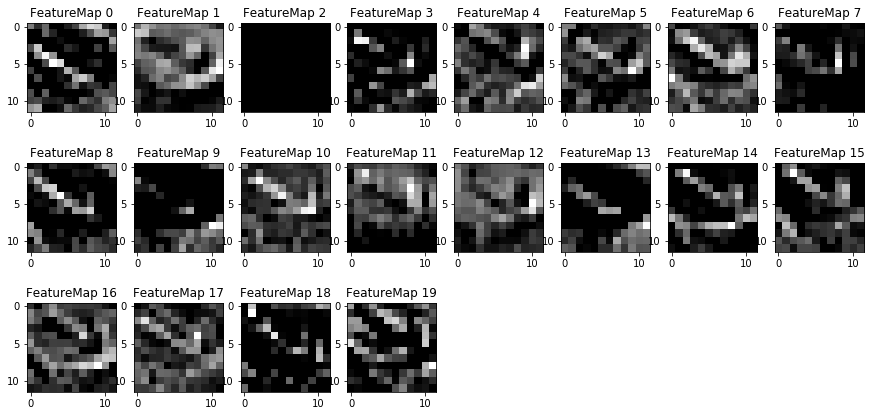

In [39]:
outputFeatureMap(input_image,CustomNet.conv3)

#### Fourth Convolutuion Layer Feature Map

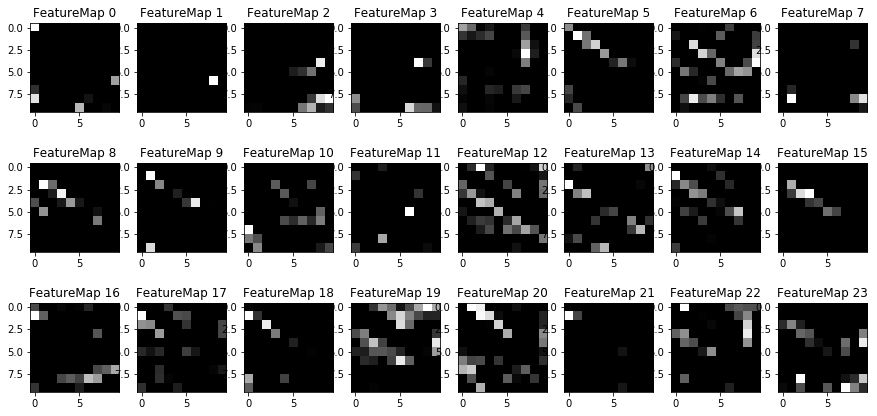

In [40]:
outputFeatureMap(input_image,CustomNet.conv4)